In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import healpy as hp
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from tqdm import *
from iminuit import Minuit, describe, Struct

# My Functions
import AssortedFunctions
from AssortedFunctions import myLog
import InverseTransform
import PointSource
import PowerLaw

# Siddharth and Laura's Stuff
from NPTFit import create_mask as cm
import constants_noh as constants
import units

In [20]:
trials = 1000
channel = 'b'
Nb = 1
conc = "S"
xsec = 1e-24
marr = [100]
ebins = [2,20]

In [3]:
# Setting basic parameters
nside = 128
npix = hp.nside2npix(nside)
   
pscmask=np.array(np.load('../fermi_data/fermidata_pscmask.npy'), dtype=bool)
exposure=np.array(np.load('../fermi_data/fermidata_exposure.npy'))
mask = cm.make_mask_total(band_mask = True, band_mask_range = 5, mask_ring = True, inner = 20, outer = 180, custom_mask = pscmask)
area_rat = (len(mask[~mask]))/len(mask)

In [4]:
# Defining some constants
r_s = 199 # scale radius, [kpc]
alpha = 0.678
N_calib = 300. # Number of subhalos with masses 10^8 - 10^10 M_sun
M_MW = 1.1e12 # [M_s]
mMin_calib = 1e8 # [M_s]
mMax_calib = 1e10 # [M_s]
mMin = 1e-5*M_MW
mMax = 0.01*M_MW # [M_s]
min_flux =np.log10(1./(np.sum(exposure[~mask])/len(exposure[~mask])))

In [5]:
def dNdm_func(m): # Subhalo mass function
    norm = N_calib / ( -.9**(-1) * (mMax_calib**(-.9) - mMin_calib**(-.9)))
    return norm * (m)**(-1.9)

N_subs = round(N_calib / ( -.9**(-1) * (mMax_calib**(-.9) - mMin_calib**(-.9))) * -.9**(-1) * (mMax**(-.9) - mMin**(-.9))) # Total number of subhalos
N_subs = np.random.poisson(N_subs)
print(N_subs)
def mCDFInv(r):
    return ( m_arr[0]**(-.9) - (m_arr[0]**(-.9) - m_arr[-1]**(-.9))*r )**(-1/.9)

rho_s2 = float(N_subs) / quad(lambda x: 4 * np.pi * x**2 * np.exp( -2./alpha * ( (x/r_s)**(alpha) - 1)), 0, constants.r_vir)[0]
def rho_Ein(r): # Einasto density Profile
    return rho_s2 * np.exp( (-2./alpha) * ( (r/r_s)**(alpha) - 1))

2207


In [6]:
r_arr = np.logspace(0, np.log10(2000), 60500) # radius values to test
r_sampler = InverseTransform.InverseTransform(lambda r: r**2 * rho_Ein(r), r_arr, nsamples=N_subs)
m_arr = np.logspace(np.log10(mMin), np.log10(mMax), 80000) # mass values to test
m_sampler = InverseTransform.InverseTransform(dNdm_func, m_arr, nsamples=N_subs)

In [21]:
PS_arr = []
F_arr = []
flux_bins = np.logspace(-15, -6, 8*8)

for i in tqdm_notebook(range(trials)):
    rval_arr = r_sampler.sample()
    mval_arr = m_sampler.sample()

    theta_arr = (np.arccos(2*np.random.rand(N_subs)-1))
    phi_arr = (2*np.pi*np.random.rand(N_subs))

    PS_set = PointSource.PointSource(mval_arr, rval_arr, theta_arr, phi_arr)
    PS_set.calcJ(conc)
    PS_arr.append(PS_set)
    
    if i == 0: PPnoxsec = PS_set.PPnoxsec(marr[0], ebins, channel)
    F_arr.append(np.histogram(PS_set.J.value[~mask[PS_set.pixels]] * xsec * PPnoxsec, bins=flux_bins)[0])

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

/home/jean/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


[1.43730061e+70 2.17516420e+70 1.55031606e+70 ... 1.67976578e+70
 3.14229538e+71 1.99000721e+70]


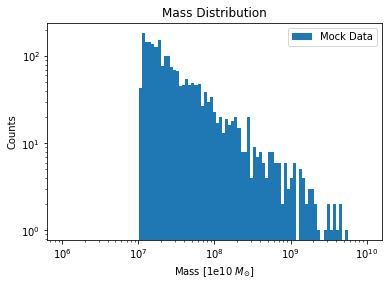

In [22]:
plt.hist(PS_set.Mvir/units.M_s, np.logspace(6, 10, 100), label="Mock Data")
print(PS_set.Mvir)
#plt.plot(mass_arr*1e10, 10**(8.6)*(mass_arr*1e10)**(-.9))
plt.title("Mass Distribution")
plt.ylabel("Counts")
plt.xlabel("Mass [1e10 $M_{\odot}$]")
plt.xscale("log")
plt.yscale("log")
plt.legend()

In [23]:
min_flux_ind = np.argmin(np.abs(flux_bins - 10.**(min_flux)))
flux_bins2 = flux_bins[min_flux_ind:]
F_arr = np.array(F_arr).astype(float)
for i in range(len(F_arr)):
    F_arr[i][F_arr[i]==0] = 1e-50

F_ave = (np.median(F_arr, axis=0))[min_flux_ind:]
max_flux = np.log10(flux_bins2[np.argmax(F_ave < 1e-20)])

dF = np.diff(flux_bins2)
dN = np.array(F_ave)/(4*np.pi*(180/np.pi)**2*area_rat)
F = (np.array(flux_bins2)[:-1]+np.array(flux_bins2)[1:])/2.

/home/jean/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: InitialParamWarning: errordef is not given. Default to 1.
  """Entry point for launching an IPython kernel.


FCN = 0.011095975486782792 
 TOTAL NCALL = 38 
 NCALLS = 38 
 
 
 EDM = 6.713717612271134e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,A,-13.4025,0.848471,0,0,-16.0,1.0,
2,n1,0.16537,0.942931,0,0,-10.0,10.0,
3,n2,-10,1,0,0,,,FIXED
4,Fb1,-9.28571,1,0,0,,,FIXED


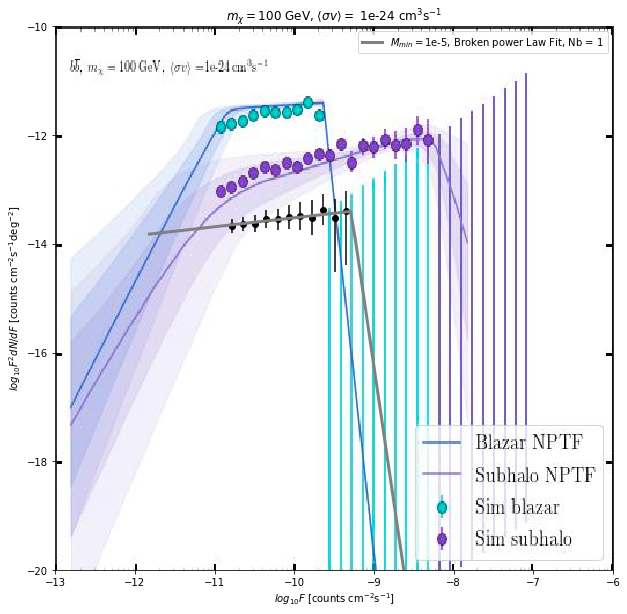

In [24]:
plt.figure(figsize=(10,10))
img = plt.imread("../LauraF2dNdF/100"+str(xsec)+".png")
plt.imshow(img, extent=[-13,-6, -20,-10], aspect='auto')

poisson = (trials==1)

yerr_up = (AssortedFunctions.PandGErrors(F_arr, poisson))[1][min_flux_ind:]
yerr_up = yerr_up/np.log(10) / dN /(4*np.pi*(180/np.pi)**2*area_rat)

yerr_dn = (AssortedFunctions.PandGErrors(F_arr, poisson))[0][min_flux_ind:]
yerr_dn = yerr_dn/np.log(10) / dN /(4*np.pi*(180/np.pi)**2*area_rat)
delta_flux = max_flux - min_flux
exec(PowerLaw.genMinuitString( Nb, "-14", "(-16,1)", "1.", "0.01", "(-10.,10.)", "1e-3", "-0.5", "(0, "+str(delta_flux)+")", ".1", "-10.", str(max_flux), vmin=min_flux, vmax=max_flux ))
minuit.migrad()
results = []
for val in minuit.values:
    results.append(minuit.values[val])
plt.errorbar(myLog(F), myLog(F**2*dN/dF), yerr=[yerr_up, yerr_dn], fmt='o', c="black")
F_test = np.logspace(min_flux-1, max_flux+1, 8*8)
plt.plot(myLog(F_test), PowerLaw.simple_power(myLog(F_test), *results), zorder=5, linewidth=3, c="grey", label="$M_{min}=$1e-5, Broken power Law Fit, Nb = " +str(Nb))
plt.xlim(-13, -6)
plt.ylim(-20, -10)
plt.title("$m_{\chi} = "+str(marr[0])+"$ GeV, $\\langle \sigma v \\rangle =$ "+str(xsec)+" cm$^3$s$^{-1}$")
plt.ylabel("$log_{10} F^2dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]")
plt.xlabel("$log_{10} F$ [counts cm$^{-2}$s$^{-1}$]")
plt.legend()
plt.show()
plt.close()